# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [682]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [683]:
# 데이터셋 종류 :
data = load_breast_cancer()

In [684]:
input = data.data #feature
output = data.target #0,1로 구분됨

In [685]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [686]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

[참고자료]

https://velog.io/@olxtar/PyTorch-Tensor%EC%9D%98-Type

data type

- 32-bit floating Point : FloatTensor

- 64-bit floating Point : DoubleTensor

- 16-bit floating Point : HalfTensor

- 8-bit integer : ByteTensor(unsigned), CharTensor(signed)

- 16-bit integer : ShortTensor

- 32-bit integer : IntTensor

- 64-bit integer : LongTensor

PyTorch의 Tensor 데이터 타입은 위와 같으며 보통 실수 계산을 하기 위해서는 FloatTensor

정수를 사용하기 위해서는 LongTensor를 사용

Boolean, 즉 True/False 사용 시 ByteTensor를 사용한다.

In [687]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수 (인덱스를 인자로 받으며, 샘플은 예제와 레이블을 한 쌍으로하여 둘을 하나의 튜플 형태로 반환하게 됨)

In [688]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

customdataset 해주는 이유

- 데이터를 한번에 불러오기 쉽지 않기 때문

TypeError: CustomDataset.__init__() takes 1 positional argument but 2 were given이 CustomDataset(x_train,y_train)시 발생 -> init부분 코드 수정

[참고자료]

https://didu-story.tistory.com/85

In [689]:
batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

dataloader의 역할

인자로 주어진 dataset을 통해 데이터셋의 샘플들을 batch size에 맞게 미니 배치를 구성하는 역할


[pytorch모델에 데이터 입력 순서]

1. dataset을 확장한 custom dataset을 생성

2. custom dataset -> dataloader 생성

3. 각 epoch 의 매 반복마다 만들어진 mini-batch를 이용해 학습


[데이터셋의 style]

1. map-style
- torch.utils.data.Dataset을 상속받아 구현
- [idx]를 통해 인덱스에 해당하는 샘플 지정 가능 (숫자,문자모두가능)
- map-stype은 _len()_, _getitem_() method 두가지를 구현해야함.

2. iterable-style
- torch.utils.data.IterableDataset을 상속받아 구현
- iter(Dataset)형태로 사용가능 : 데이터셋의 샘플들을 순차적으로 하나씩 가져오도록 지정
- _iter_() :  매 iteration마다 샘플 하나씩 출력하는 바복적인 객체 반환 하는 method를 반드시 구현해야함.

=> 각 style에 맞는 method 잘 구현했다면 dataloader는 다른 처리없이 dataset instance를 인자로 주면 실행가능함

[참고자료]

https://wikidocs.net/57165

https://heekangpark.github.io/ml-shorts/pytorch-dataset-dataloader

In [690]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,2, bias=True),
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [691]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 2, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

*nn.BatchNorm1d*

정규화 모듈 (배치 정규화)

* 배치 정규화 ? : 입력 데이터를 정규화 -> 모델의 수렴을 도움

1d : 1차원 입력에 대해서만 정규화 수행

`torch.nn.BatchNorm1d(num_features, eps, momentum, affine, track_running_stats)`

num_features : 입력 데이터의 채널수 지정 (무조건 지정해줘야함)

eps : 분모에 더해지는 작은값 (분모=0방지), (1e-05가 기본값)

momentum : 이전 배치의 평균, 분산을 얼마나 반영할지 지정, (기본값 0.1) (단순 평균 : None으로 지정)

affine : 정규화된 값을 확대 or 이동 시킬지 여부 지정 (True가 기본값)

track_running _stats : 배치 정규화 효과 추적 여부 지정 (기본값은 True)

- nn.BarchNorm2d : 2차원 이미지 데이터에 대한 배치 정규화 / 지정값들은 1d와 동일

[참고자료]

https://wikidocs.net/195419

https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html : 정규화 식과 정확한 함수 지정값 설

In [692]:

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

init.uniform : 균일 분포로 초기화

이처럼 init.분포 꼴로 해당 분포로 초기화 시켜줌 (normal,..)

xavier 사용시, 고정된 표준편차를 사용하지 않는다는 것이 특징

이전 hidden layer node 수인 fan_in, 현재 hidden layer node 수인 fan_out을 고려해 만들어져 활성값을 고르게 분포하도록 지정함.

xavier-uniform : unif(-a,a)꼴로 초기화된다고 한다면

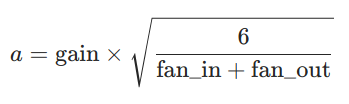

[참고자료]

https://supermemi.tistory.com/entry/CNN-%EA%B0%80%EC%A4%91%EC%B9%98-%EC%B4%88%EA%B8%B0%ED%99%94-Weight-Initialization-PyTorch-Code : xavier 사용했을 때 fan_in & fan_out이 어떻게 사용되는지 수식으로 확인 가능함.



In [693]:
model = Model().to(device)
model.apply(init_weights)

<ipython-input-692-6196a47a4462>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

In [694]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


In [695]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [696]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.6551405787467957
10 0.5042113065719604
20 0.4169006049633026
30 0.3928559124469757
40 0.38005268573760986
50 0.39754462242126465
60 0.3835339844226837
70 0.3707054853439331
80 0.37047240138053894
90 0.3676254153251648


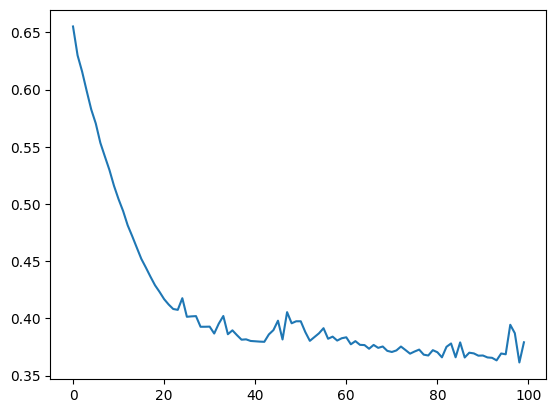

In [697]:
plt.plot(losses)
plt.show()

In [698]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [699]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.01647019 0.98352975]
argmax를 한 후의 output은 1
accuracy는 0.9181286549707602


##lr = 0.05

In [702]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list? 가끔 ML할 때 해준다고 함.)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,2, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 2, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-702-9fede1e14ebc>:81: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [703]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.05)

In [704]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.6635677218437195
10 0.6197441816329956
20 0.41984060406684875
30 0.4048318564891815
40 0.6851072311401367
50 0.685114860534668
60 0.6851164698600769
70 0.6851169466972351
80 0.6851171255111694
90 0.6851170063018799


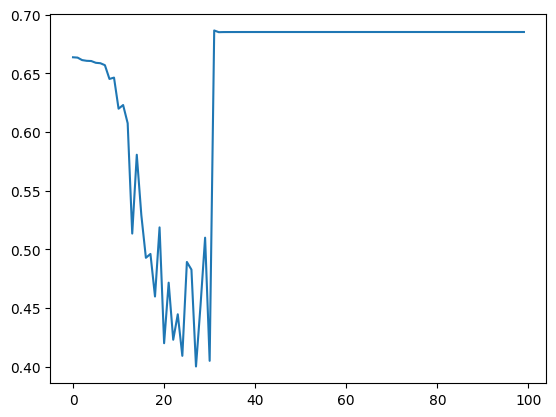

In [705]:
plt.plot(losses)
plt.show()

In [706]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [707]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.8719478e-05 9.9998128e-01]
argmax를 한 후의 output은 1
accuracy는 0.6257309941520468


## activation = relu

In [708]:
#relu 구현
class relu:
  def __init__(self): #초기화
    self.out = None

  def forward(self,z):
    return torch.max(torch.tensor(0, dtype=z.dtype, device=z.device),z) # max값을 취함

relu 구현 참고 링크

https://cding.tistory.com/104]


```
class ReLU:
    def __init__(self):
        self.out = None

    def forward(self, z):
        self.out = z
        self.out[self.out <= 0] = 0
        return self.out

    def backward(self, dout):
        self.out[self.out > 0] = 1
        return self.out * dout
```

링크 속 구현 코드 (링크 내 다양한 활성화함수 코드 구현됨)

## SGD

In [709]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list? 가끔 ML할 때 해준다고 함.)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,2, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 2, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-709-9fede1e14ebc>:81: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [710]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)

In [711]:
losses = []
for epoch in range(100):

  optimizer_sgd.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer_sgd.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.6717848777770996
10 0.6281248927116394
20 0.6127654314041138
30 0.6042484045028687
40 0.5978968739509583
50 0.5935328006744385
60 0.5907191634178162
70 0.5870545506477356
80 0.5828157663345337
90 0.579874575138092


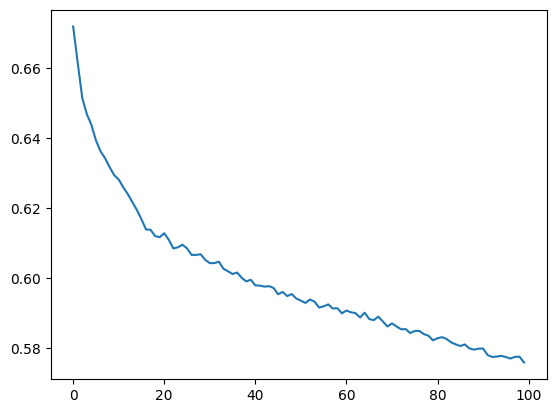

In [712]:
plt.plot(losses)
plt.show()

In [713]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [714]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.2967468 0.7032532]
argmax를 한 후의 output은 1
accuracy는 0.8771929824561403


# wine data

[활성화함수 선택]

- multi-layer perceptron : ReLu계열
- Convolution neural network : ReLu계열
- Recurrent neural network : sigmoid / Tanh

[사용한 활성화 함수]

1. relu : max(0,x) / 간단하고 계산 효율적 ( sigmoid, tanh보다 sgd를 사용했을 때 수렴속도 6배 빠름) / gradient vanishing 문제에서도 나음


2. sigmoid : 0~1사이의 값을 가짐. 층을 깊이 쌓으면 gradient vanishing 문제 있음

3. tanh : zero-centric함수 / -1~1사이의 값 / sigmoid보다 gradient값이 커 loss 더 빨리 최소화 가능하지만 gradient vanishing 문제음

4. softplus : 도함수가 sigmoid이며, unbounded above function / 0~inf
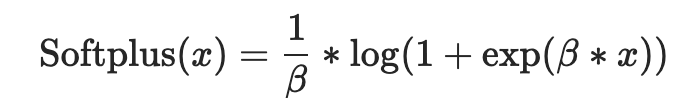

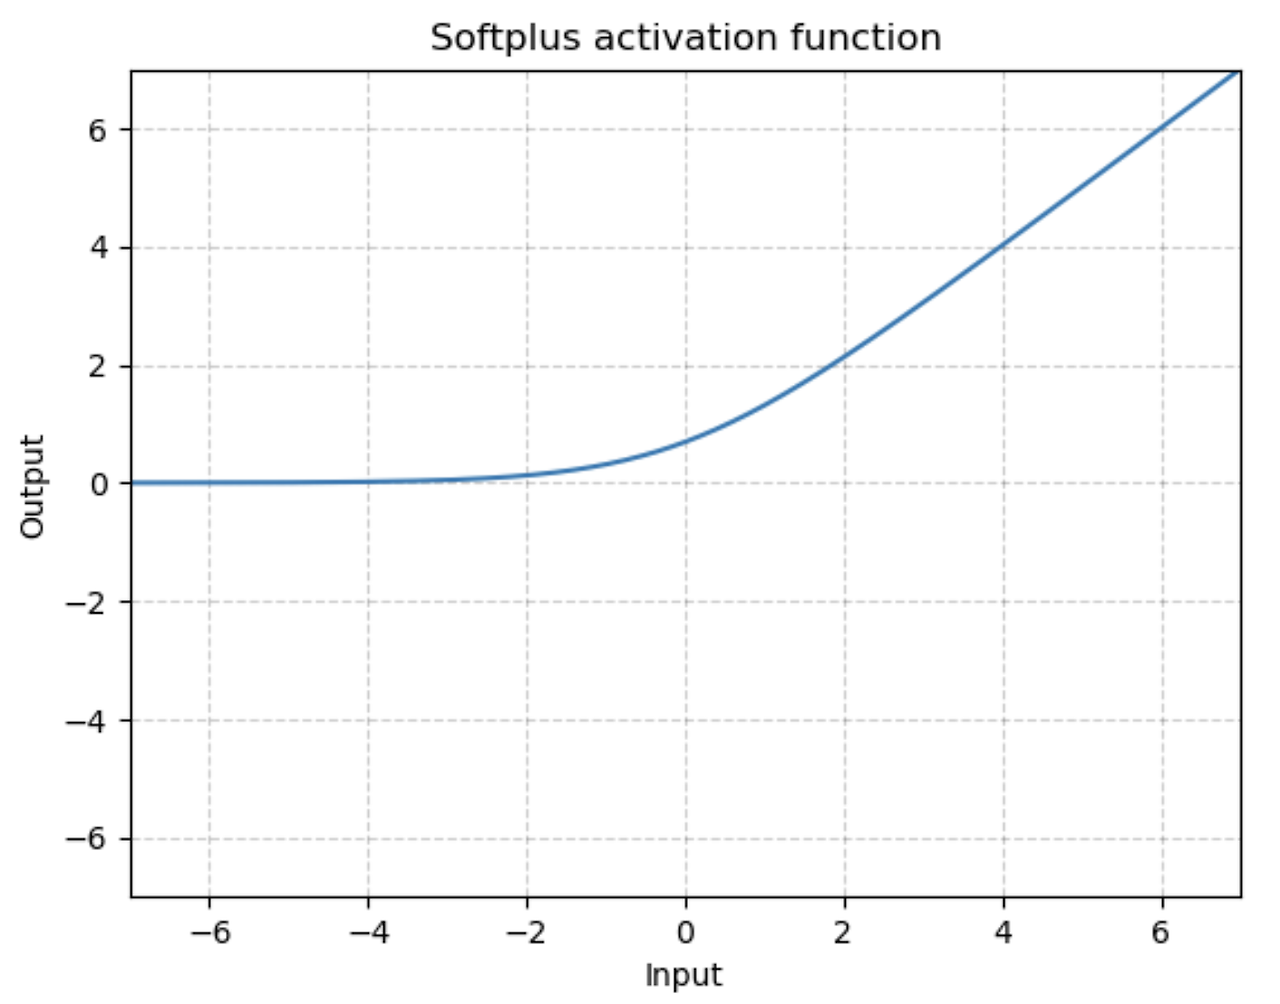

5. swish = SiLU(Sigmoid Linear Unit) : sigmoid를 씌운 값의 곱으로 이루어짐 / x*sigma(x) / gating을 활용해 0보다 작은 곳에서 0이 되지 않도록 bounded below한 함수
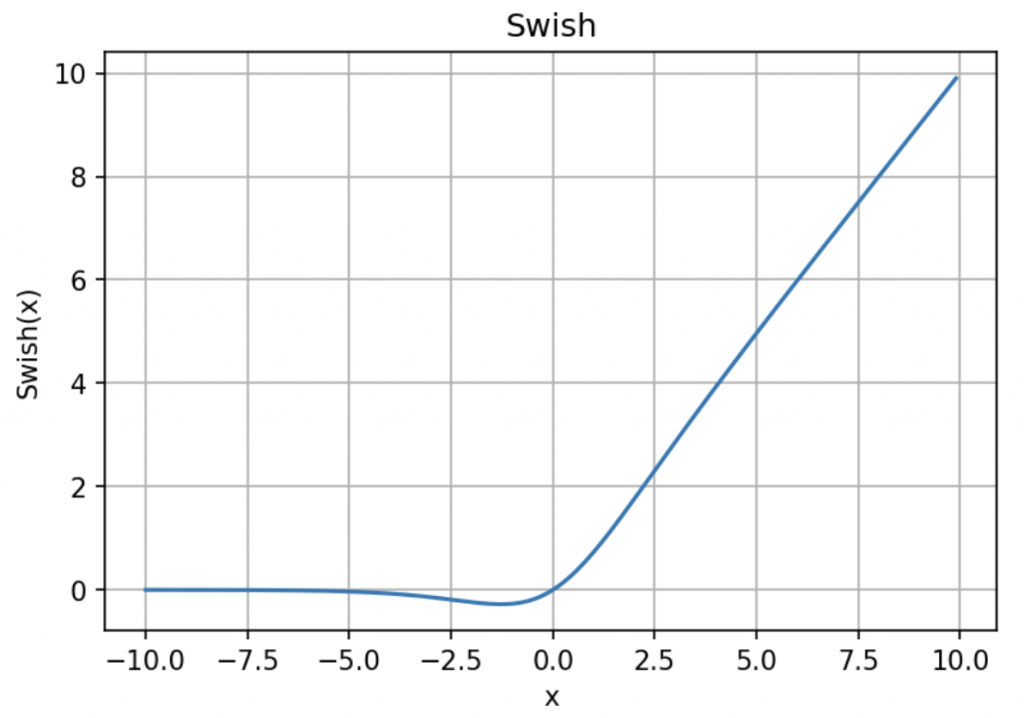

[사용한 optimizer]

1. adam

2. sgd

3. adagrad : step별로 lr을 줄임 (optimizer의 step은 답에 가까워 질수록 줄어들어야 최적의 해를 구할 수 있음 -> 이를 구현한 것

step별로 lr을 줄이다보니 최적의 해 도달 전에 0에 가까워지는 문제 발생 -> 이를 방지하기 위해 RMSprop사용


[활성화함수 참고 자료]

https://sanghyu.tistory.com/182

[optimizer 참고 자료]

https://velog.io/@reversesky/Optimizer%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%A0%95%EB%A6%AC


### 데이터

In [589]:
from sklearn.datasets import load_wine
data = load_wine()
input = data.data #feature
output = data.target #0,1,2로 구분됨

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

print(x_train[0])
print(y_train[0])

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03])
tensor(0)


In [590]:
input.shape

(178, 13)

In [591]:
output

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

### relu & adam

In [592]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.ReLU(),
          nn.Linear(398,15, bias=True),
          nn.ReLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 13, hidden_layer1 = 398
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-592-a9d6d6c870a5>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


#### lr = 0.01

In [593]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [594]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.9692224860191345
10 0.7868896126747131
20 0.6789904236793518
30 0.6048315167427063
40 0.5908252596855164
50 0.5885493159294128
60 0.5826841592788696
70 0.5703791975975037
80 0.5599335432052612
90 0.5596808791160583


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


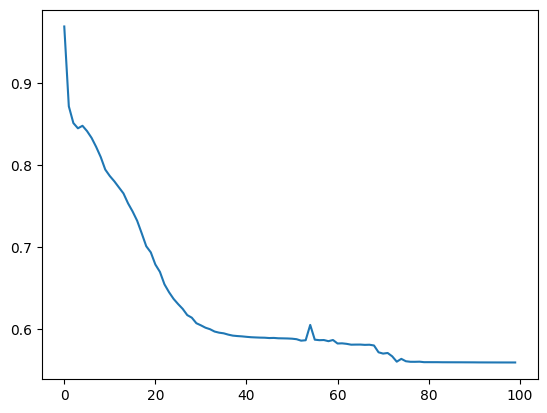

In [595]:
plt.plot(losses)
plt.show()

In [596]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999928e-01 4.4995755e-07 2.0423641e-07]
argmax를 한 후의 output은 0
accuracy는 0.9259259259259259


#### lr = 0.001 -> 정확도 ;0.9629629629629629

In [597]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [598]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.5595322251319885
10 0.5519402623176575
20 0.5515904426574707
30 0.5515216588973999
40 0.5514985918998718
50 0.5514840483665466
60 0.551475465297699
70 0.5514699816703796
80 0.5514662861824036
90 0.5514638423919678


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


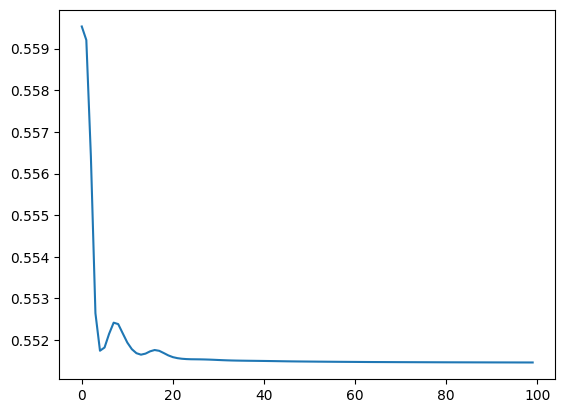

In [599]:
plt.plot(losses)
plt.show()

In [600]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.999927e-01 7.272725e-06 5.445375e-09]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


### relu & sgd

In [601]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.ReLU(),
          nn.Linear(398,15, bias=True),
          nn.ReLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-601-d3aa6dc2eb39>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


#### lr = 0.01

In [602]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [603]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0935661792755127
10 0.9887017011642456
20 0.9328476786613464
30 0.9040456414222717
40 0.8844529390335083
50 0.8698295950889587
60 0.8592867255210876
70 0.8504838347434998
80 0.8455061912536621
90 0.8409323692321777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


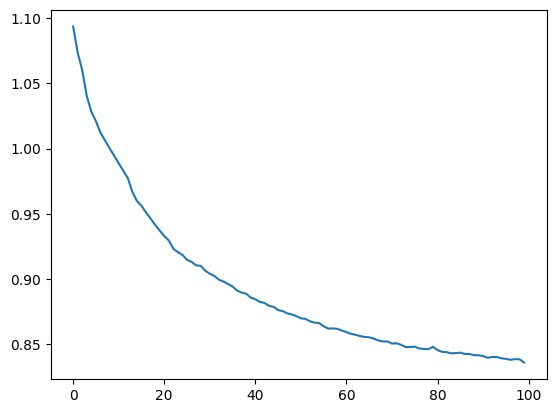

In [604]:
plt.plot(losses)
plt.show()

In [605]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9302293  0.0472633  0.02250746]
argmax를 한 후의 output은 0
accuracy는 0.6666666666666666


#### lr = 0.001

In [606]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.001)

In [607]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 0.8358228802680969
10 0.8343220949172974
20 0.8336302042007446
30 0.8331806063652039
40 0.8327469825744629
50 0.8323288559913635
60 0.831914484500885
70 0.8314979076385498
80 0.8310639262199402
90 0.8305994272232056


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


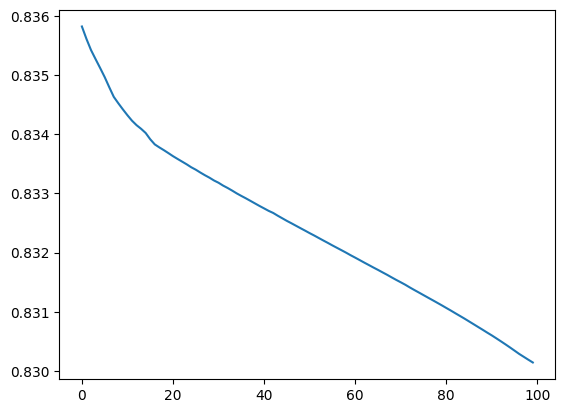

In [608]:
plt.plot(losses)
plt.show()

In [609]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.94148004 0.03970723 0.0188128 ]
argmax를 한 후의 output은 0
accuracy는 0.6666666666666666


### relu & RMSprop

In [610]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.ReLU(),
          nn.Linear(398,15, bias=True),
          nn.ReLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-610-d3aa6dc2eb39>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [611]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

In [612]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.049312949180603
10 0.8485270738601685
20 0.8282352089881897
30 0.7002026438713074
40 0.7073054313659668
50 0.6143292188644409
60 0.5879098176956177
70 0.5720173716545105
80 0.5790700316429138
90 0.5705611109733582


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


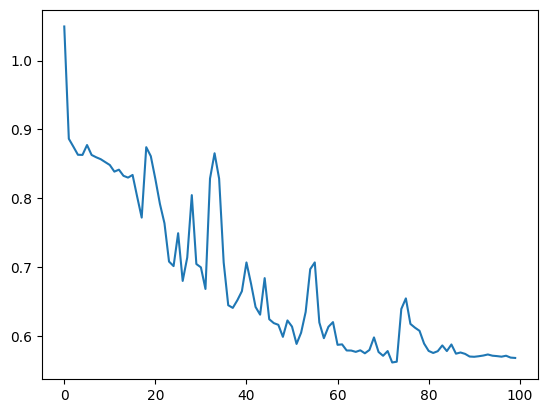

In [613]:
plt.plot(losses)
plt.show()

In [614]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9994922e-01 1.8430619e-05 3.2319364e-05]
argmax를 한 후의 output은 0
accuracy는 0.9074074074074074


### sigmoid & adam

In [615]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-615-136a56d09821>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [616]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [617]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.088232398033142
10 0.923187255859375
20 0.8481801748275757
30 0.8076837658882141
40 0.758213222026825
50 0.7236024141311646
60 0.650415301322937
70 0.6388932466506958
80 0.5955390334129333
90 0.6121755242347717


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


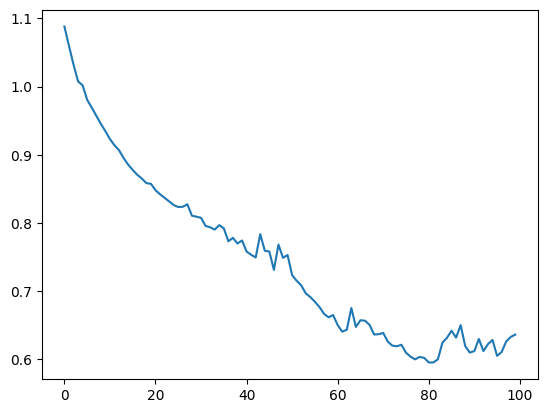

In [618]:
plt.plot(losses)
plt.show()

In [619]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.98383594 0.00395247 0.01221167]
argmax를 한 후의 output은 0
accuracy는 0.9074074074074074


### sigmoid & sgd

In [620]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-620-cae26743a6bb>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [621]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [622]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1147509813308716
10 1.1078009605407715
20 1.103990912437439
30 1.1011420488357544
40 1.0989148616790771
50 1.096868872642517
60 1.0946860313415527
70 1.0925447940826416
80 1.090416669845581
90 1.0887782573699951


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


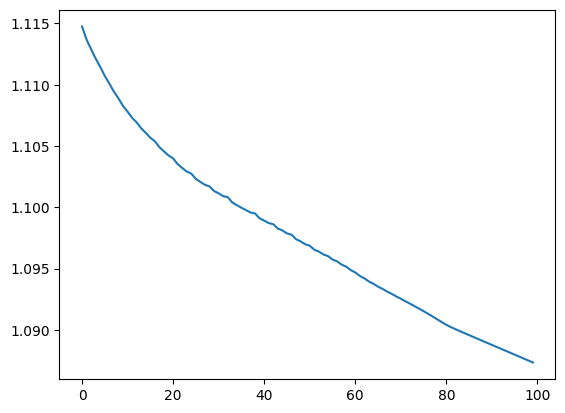

In [623]:
plt.plot(losses)
plt.show()

In [624]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.6365886  0.23617591 0.12723555]
argmax를 한 후의 output은 0
accuracy는 0.3333333333333333


### sigmoid & RMSprop

In [625]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-625-6b8e45cc8f81>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [626]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

In [627]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1028081178665161
10 1.084519863128662
20 1.0844581127166748
30 1.0844584703445435
40 1.084457278251648
50 1.0844687223434448
60 1.0848335027694702
70 1.084517478942871
80 1.0844645500183105
90 1.084464430809021


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


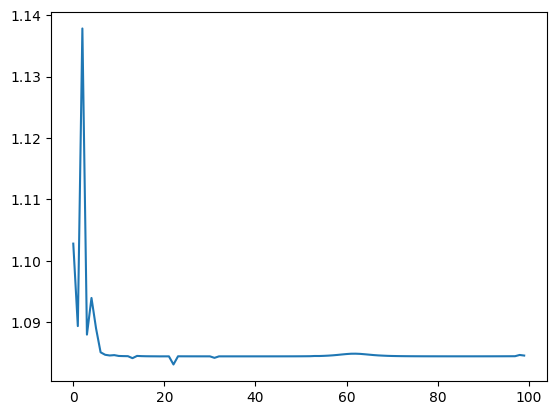

In [628]:
plt.plot(losses)
plt.show()

In [629]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.35822412 0.5139769  0.12779902]
argmax를 한 후의 output은 1
accuracy는 0.3888888888888889


### tanh & adam

In [630]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Tanh(),
          nn.Linear(398,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Tanh(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-630-e51ad7ea47dc>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [631]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [632]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.095482587814331
10 0.8003095984458923
20 0.6984851956367493
30 0.6168436408042908
40 0.6547276973724365
50 0.6146397590637207
60 0.62093186378479
70 0.661678671836853
80 0.6073175668716431
90 0.6300368309020996


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


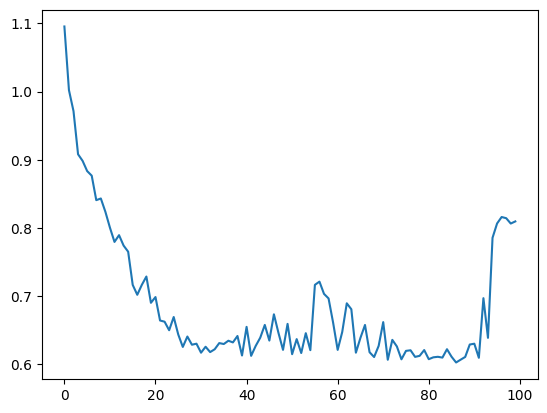

In [633]:
plt.plot(losses)
plt.show()

In [634]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9855608e-01 3.4318867e-04 1.1007243e-03]
argmax를 한 후의 output은 0
accuracy는 0.7777777777777778


### tanh & sgd

In [635]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Tanh(),
          nn.Linear(398,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Tanh(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-635-fb4c3321c41d>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [636]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [637]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0762863159179688
10 1.061599612236023
20 1.0516637563705444
30 1.0459973812103271
40 1.0063505172729492
50 1.038334608078003
60 1.0297497510910034
70 1.0232828855514526
80 1.0267837047576904
90 1.0511852502822876


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


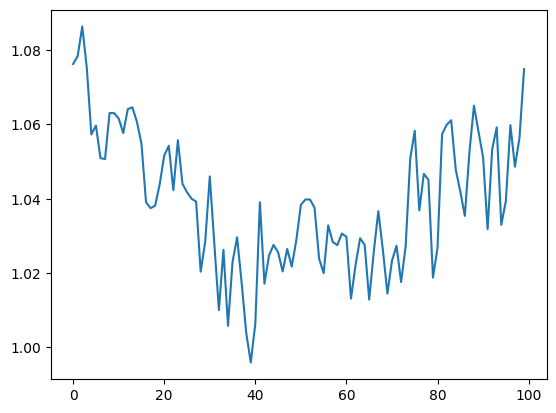

In [638]:
plt.plot(losses)
plt.show()

In [639]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.471639   0.2811209  0.24724013]
argmax를 한 후의 output은 0
accuracy는 0.5185185185185185


### tanh & RMSprop

In [640]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Tanh(),
          nn.Linear(398,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Tanh(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Tanh()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-640-e51ad7ea47dc>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [641]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

In [642]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0883499383926392
10 1.0846562385559082
20 1.0844758749008179
30 1.0844658613204956
40 1.0844844579696655
50 1.0846744775772095
60 1.0846349000930786
70 1.0845112800598145
80 1.0845065116882324
90 1.0845800638198853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


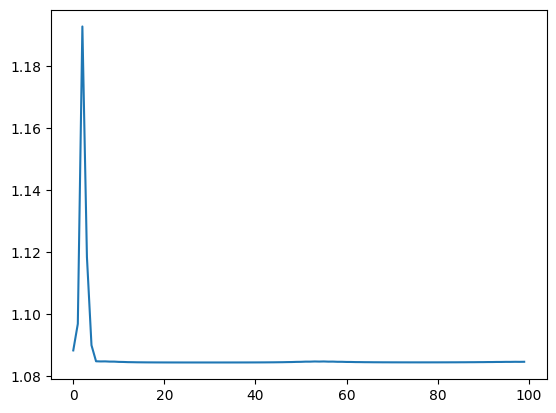

In [643]:
plt.plot(losses)
plt.show()

In [644]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.36243147 0.5128481  0.12472042]
argmax를 한 후의 output은 1
accuracy는 0.3888888888888889


### softplus & adam

In [645]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Softplus(),
          nn.Linear(398,15, bias=True),
          nn.Softplus(),
          nn.Linear(15,3, bias=True),
          nn.Softplus()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Softplus(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Softplus()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Softplus()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-645-fca2411f416f>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [646]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [647]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.1562604904174805
10 0.6671180725097656
20 0.5847103595733643
30 0.5574386715888977
40 0.5519550442695618
50 0.5515812039375305
60 0.5515040755271912
70 0.5514752864837646
80 0.551465630531311


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


90 0.5514610409736633


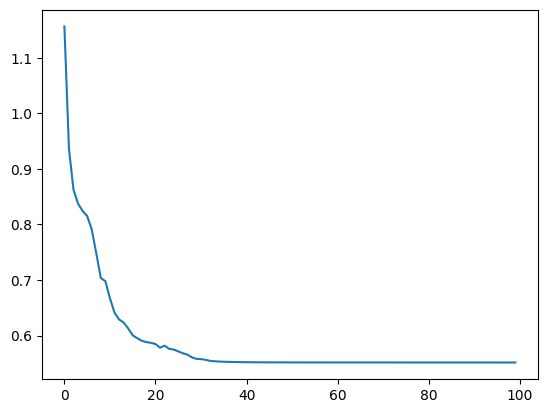

In [648]:
plt.plot(losses)
plt.show()

In [649]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999964e-01 3.7009934e-07 1.4236302e-15]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


### softplus & sgd

In [650]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Softplus(),
          nn.Linear(398,15, bias=True),
          nn.Softplus(),
          nn.Linear(15,3, bias=True),
          nn.Softplus()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Softplus(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Softplus()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Softplus()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-650-fca2411f416f>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [651]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [652]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0337430238723755
10 0.990807294845581
20 0.9697443842887878
30 0.9513901472091675
40 0.9301775097846985
50 0.9144096374511719
60 0.9018110632896423
70 0.8912389278411865
80 0.8833240270614624
90 0.876238226890564


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


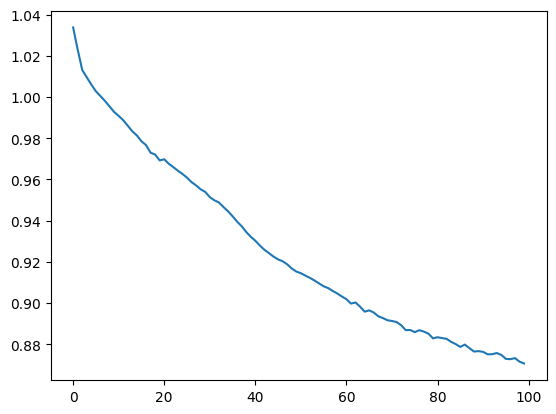

In [653]:
plt.plot(losses)
plt.show()

In [654]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9148317  0.06280572 0.02236259]
argmax를 한 후의 output은 0
accuracy는 0.6851851851851852


### softplus & RMSprop -> 정확도; 0.9629629629629629

In [655]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Softplus(),
          nn.Linear(398,15, bias=True),
          nn.Softplus(),
          nn.Linear(15,3, bias=True),
          nn.Softplus()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Softplus(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Softplus()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Softplus()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-655-520c4626f2ba>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [656]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

In [657]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.2051528692245483
10 1.2853074073791504
20 1.2852978706359863
30 1.2851918935775757
40 1.0007716417312622
50 0.8197460174560547
60 0.5916867256164551
70 0.6099667549133301
80 0.5823794603347778
90 0.5687107443809509


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


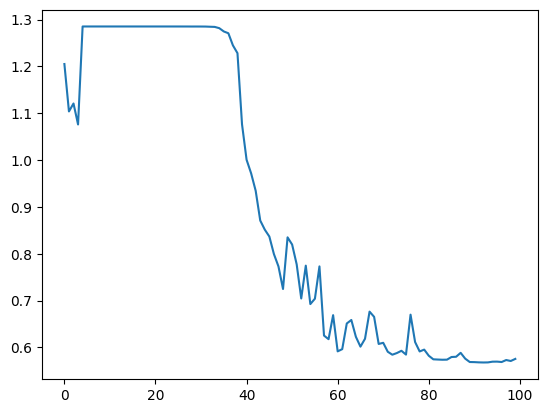

In [658]:
plt.plot(losses)
plt.show()

In [659]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999940e-01 5.4325011e-07 1.9623746e-08]
argmax를 한 후의 output은 0
accuracy는 0.8888888888888888


### Swish & adam

In [660]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.SiLU(),
          nn.Linear(398,15, bias=True),
          nn.SiLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.SiLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.SiLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): SiLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-660-7ce00d21331f>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [661]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)

In [662]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0700792074203491
10 0.6803942322731018
20 0.600074291229248
30 0.5773102045059204
40 0.5727908611297607
50 0.5685722231864929
60 0.5614925026893616
70 0.5602706074714661
80 0.5599011182785034


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


90 0.5597513318061829


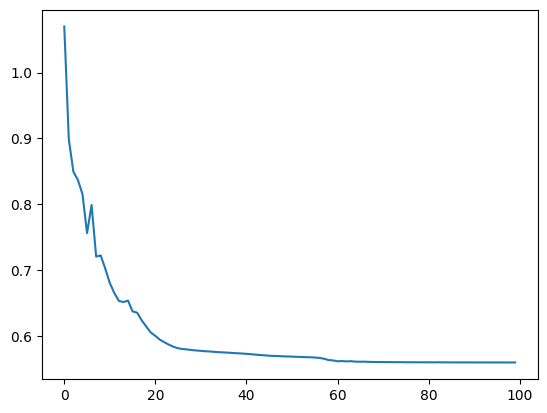

In [663]:
plt.plot(losses)
plt.show()

In [664]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999917e-01 8.4055108e-07 3.8910434e-20]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


### Swish & sgd

In [665]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.SiLU(),
          nn.Linear(398,15, bias=True),
          nn.SiLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.SiLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.SiLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): SiLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-665-e83f3b473110>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [666]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01)

In [667]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0926425457000732
10 0.9629169702529907
20 0.9492613673210144
30 0.9387573003768921
40 0.932262122631073
50 0.9241586923599243
60 0.9169372320175171
70 0.9093835353851318
80 0.9001966714859009
90 0.8903433084487915


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


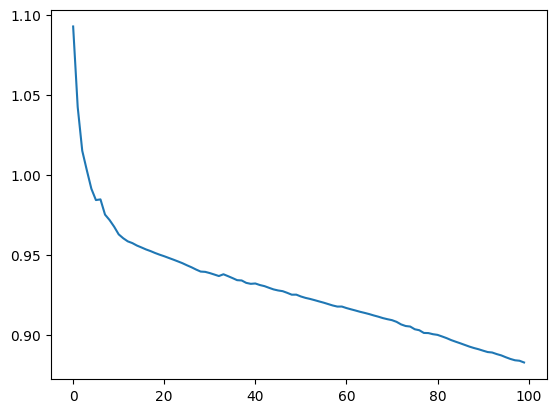

In [668]:
plt.plot(losses)
plt.show()

In [669]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.97950256 0.01920352 0.00129387]
argmax를 한 후의 output은 0
accuracy는 0.7592592592592593


### Swish & RMSprop

In [670]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self,x_train,y_train): #추후 customerdataset할 때 type error나타나서 수정함.
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #target에 해당하는 값을 2D list로 반환해줌 (왜 2D list?)
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

batch_size = 8

dataset = CustomDataset(x_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size)

model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.SiLU(),
          nn.Linear(398,15, bias=True),
          nn.SiLU(),
          nn.Linear(15,3, bias=True),
          nn.Softmax()
          ).to(device)

class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.SiLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.SiLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.SiLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): SiLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): SiLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): SiLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


<ipython-input-670-e83f3b473110>:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [671]:
loss_fn  = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

In [672]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 1.0824432373046875
10 0.9942507147789001
20 0.85781329870224
30 0.8417062163352966
40 0.8300800323486328
50 0.7761824131011963
60 0.6678832769393921
70 0.6180047392845154
80 0.6104552149772644
90 0.6041387319564819


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


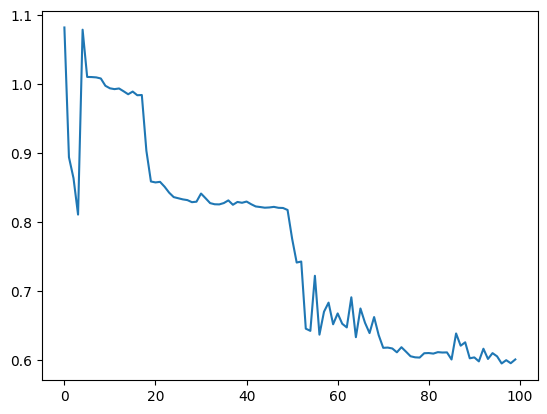

In [673]:
plt.plot(losses)
plt.show()

In [674]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999928e-01 5.2331483e-08 7.2544742e-07]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


# < 3주차 과제 2 : CNN 맛보기>

In [675]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [676]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [677]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.mp = nn.MaxPool2d(2)
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은? RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x320 and 3x10)에 의해 320이 적절함

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x)))
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x)

In [678]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [679]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [680]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

model. eval : 모델을 평가 모드로 전환 / 별도의 인수를 받지 않음 / 드롭아웃이 비활성화되며 배치 정규화의 이동평균가 분산이 업데이트되지 않음 / 모델 평가시 사용 / 성능평가에 불필요한 노이즈를 줄이고 일관된 결과 얻을 수 있

- 드롭 아웃 : 서로 연결된 layer에서 0~1 사이의 확률로 뉴런을 제거하는 기법

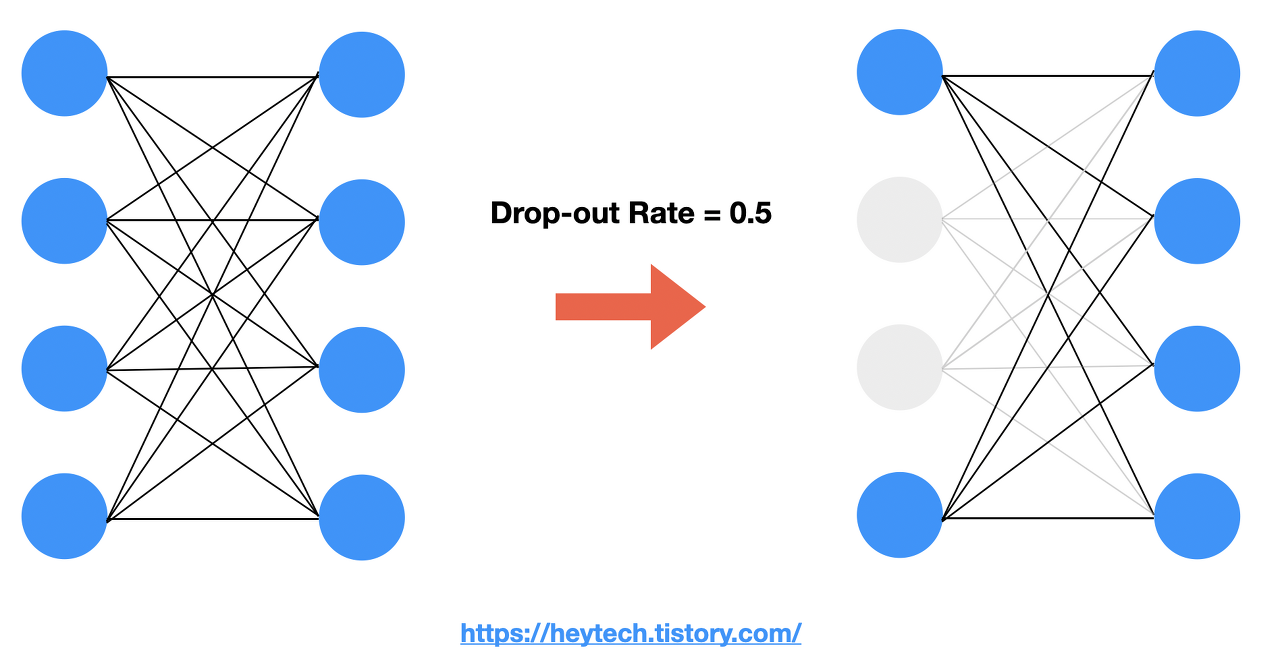

[참고자료]


https://heytech.tistory.com/127

https://wikidocs.net/195115

**nll_loss**

negative log likelihood(NLL) 손실 함수

주로 다중 클래스 분류 문제에 사용되며 cross entropy loss와 같이 모델의 output 분포와 실제 label사이의 차이를 측정하여 loss를 정의

따라서 모델의 output은 로그 확률로 주어져야하며, 타깃 label은 정수로 주어져야 함.

NLL 손실은 실제 label에 해당하는 로그 확률의 음수값으로 정의됨 ( 잘 맞출수록 손실 값 낮아짐)


```
torch.nn.NLLLoss(weight=None, ignore_index=-100, reduction='mean')
```

weight : 클래스에 대한 가중치 지정 (클래스 불균형 처리시 사용됨) 기본값 None을 사용하면 동일한 가중치 사용

ignore_index : 손실 계산시 무시할 인덱스 지정 / 기본값은 -100임

reduction : 손실값을 어떻게 줄일지 지정 / mean이 기본값 / sum, none 옵션



[참고자료]

https://wikidocs.net/194925



In [681]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303123


<ipython-input-677-e231c3a1d9a9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295860
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.272252
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.252925
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.212763
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.190009
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.115987
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.067483
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.858124
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.775340
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.533969
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.233750
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.219334
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.959157
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.040468
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.704665
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.780960
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.579745
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.725784
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.447860
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.600946
Train Epoch: 1 [13440/60

<ipython-input-680-f52337105c2a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1726, Accuracy: 9501/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.135176
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.135726
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.317928
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.079502
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.157814
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.292191
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.241656
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.265992
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.088068
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.132608
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.140108
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.131556
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.128626
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.288751
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.187446
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.128741
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.248274
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.162861
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.159707
Train Epoch: 2 [12

KeyboardInterrupt: 